# Example-19: Phase space structure exploration by chaos indicators

In [1]:
# Import

import numpy

import jax
from jax import jit
from jax import vmap

# Test symplectic mapping and corresponding inverse

from tohubohu.util import forward2D
from tohubohu.util import inverse2D

# Indicators

from tohubohu import rem
from tohubohu import exponential
from tohubohu import frequency
from tohubohu import ld

# Plotting

from matplotlib import pyplot as plt
from matplotlib import colormaps

cmap = colormaps.get_cmap('viridis')
cmap.set_bad(color='lightgray')

In [2]:
# Set data type

jax.config.update("jax_enable_x64", True)

In [3]:
# Set device

device, *_ = jax.devices('cpu')
jax.config.update('jax_default_device', device)

In [4]:
# Set initial grid

n = 1001

qs = jax.numpy.linspace(-1.0, 1.0, n)
ps = jax.numpy.linspace(-1.0, 1.0, n)
xs = jax.numpy.stack(jax.numpy.meshgrid(qs, ps, indexing='ij')).swapaxes(-1, 0).reshape(n*n, -1)
xs.shape

(1002001, 2)

In [5]:
# Set indicators
# Note, jacfwd is make mapping over initial grid memory efficient

length = 2**10

level = 1.0E-16
knobs = jax.numpy.array([0.47, 0.00])

fn_rem = jit(rem(length, forward2D, inverse2D, epsilon=1.0E-16))
fn_fr = jit(frequency(exponential(length), forward2D))
fn_ld = jit(ld(exponential(length), forward2D, inverse2D))

@jit
def indicator_rem(x):
    return jax.numpy.log10(level + fn_rem(x, knobs))

@jit
def indicator_fr(x):
    return jax.numpy.log10(level + jax.numpy.linalg.norm(jax.jacfwd(fn_fr)(x, knobs)))

@jit
def indicator_ld(x):
    return jax.numpy.stack(fn_ld(x, knobs))

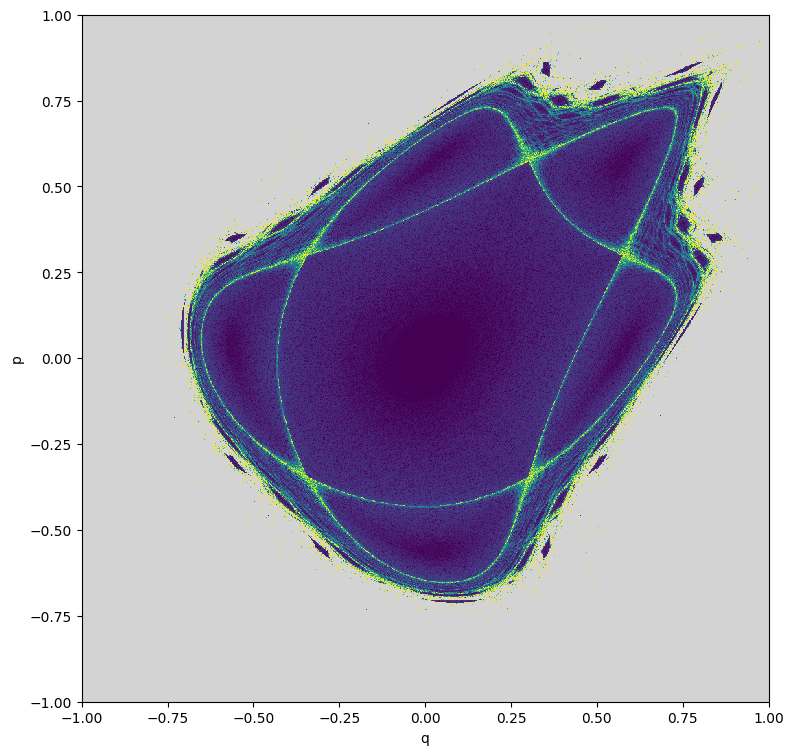

CPU times: user 47.1 s, sys: 649 ms, total: 47.7 s
Wall time: 9.16 s


In [6]:
%%time

# Evaluate indicator (REM)

out = jit(vmap(indicator_rem))(xs).block_until_ready()

# Winsorize data

data = numpy.array(out)
data[data < -15.0] = -15.0
data[data > -3.0] = -3.0
data = data.reshape(n, n)

# Plot 

plt.figure(figsize=(8, 8))
plt.imshow(data, aspect='equal', vmin=-15.0, vmax=-3.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-1.0, 1.0, -1.0, 1.0))
plt.xlabel('q')
plt.ylabel('p')
plt.tight_layout()
plt.show()

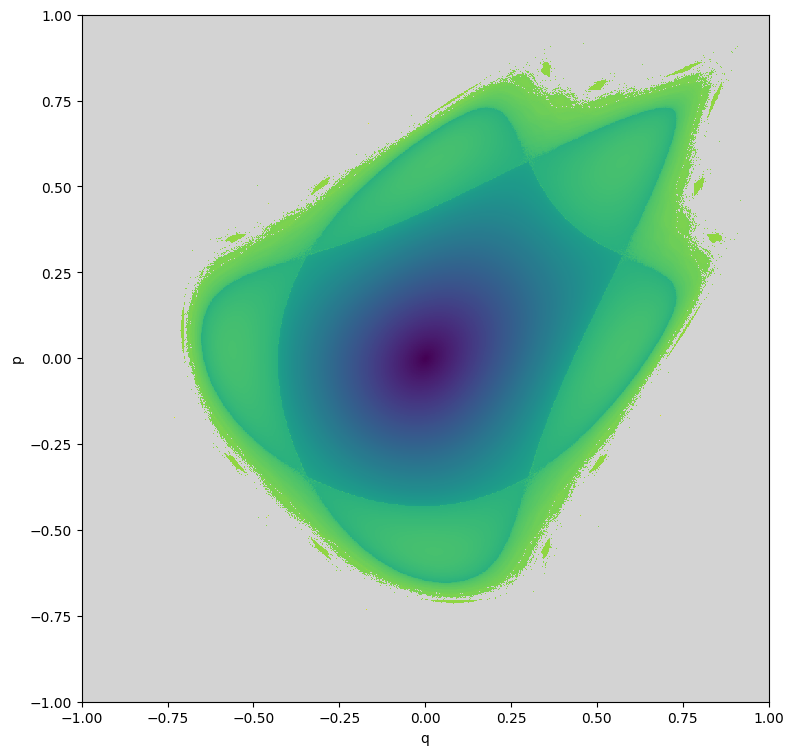

CPU times: user 1min 2s, sys: 802 ms, total: 1min 3s
Wall time: 13.1 s


In [7]:
%%time

# Evaluate indicator (LD)

out_a, out_b = jit(vmap(indicator_ld))(xs).T.block_until_ready()

plt.figure(figsize=(8, 8))
plt.imshow((out_a + out_b).reshape(n, n), aspect='equal', vmin=0.0, vmax=2.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-1.0, 1.0, -1.0, 1.0))
plt.xlabel('q')
plt.ylabel('p')
plt.tight_layout()
plt.show()

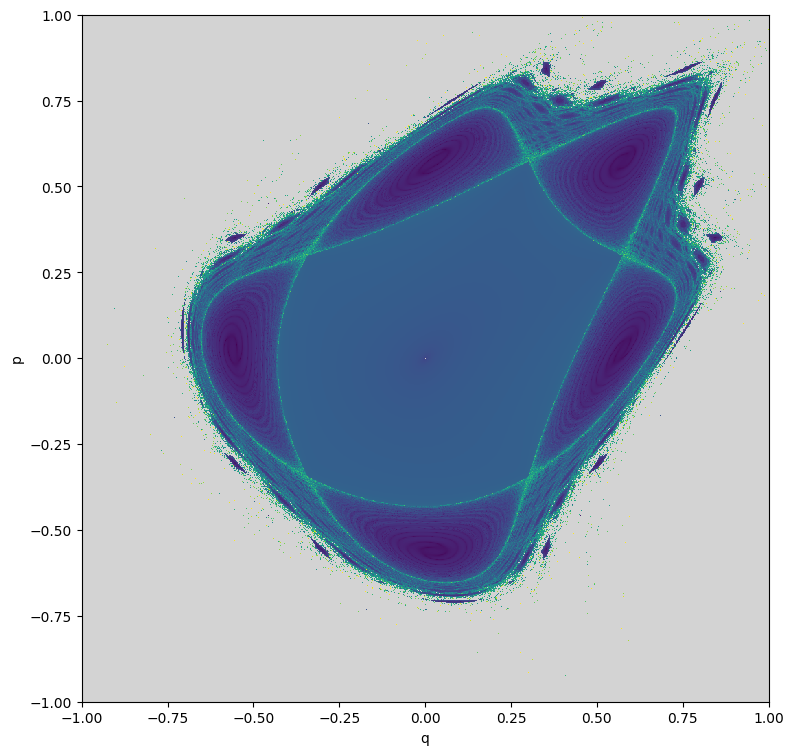

CPU times: user 2min 18s, sys: 1.8 s, total: 2min 20s
Wall time: 24 s


In [8]:
%%time

# Evaluate indicator (frequency)

out = jit(vmap(indicator_fr))(xs).block_until_ready()

# Winsorize data

data = numpy.array(out)
data[data < -9.0] = -9.0
data[data > 16.0] = 16.0
data = data.reshape(n, n)

# Plot 

plt.figure(figsize=(8, 8))
plt.imshow(data, aspect='equal', vmin=-9.0, vmax=16.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-1.0, 1.0, -1.0, 1.0))
plt.xlabel('q')
plt.ylabel('p')
plt.tight_layout()
plt.show()